In [1]:
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import numpy as np
import torch
from torch.amp import GradScaler, autocast

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/wikiart-caption-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wikiart-caption-dataset/valid_data_with_captions.csv
/kaggle/input/wikiart-caption-dataset/test_data_with_captions.csv
/kaggle/input/wikiart-caption-dataset/train_data_with_captions.csv


In [3]:
# Load and drop 'style' column
data_train = pd.read_csv('/kaggle/input/wikiart-caption-dataset/train_data_with_captions.csv').drop('style', axis=1)
valid_data = pd.read_csv('/kaggle/input/wikiart-caption-dataset/valid_data_with_captions.csv').drop('style', axis=1)
test_data = pd.read_csv('/kaggle/input/wikiart-caption-dataset/test_data_with_captions.csv').drop('style', axis=1)

# Downsample each to 10k
data_train = data_train.sample(n=5000, random_state=42).reset_index(drop=True)
valid_data = valid_data.sample(n=5000, random_state=42).reset_index(drop=True)
test_data = test_data.sample(n=10000, random_state=42).reset_index(drop=True)

print("Train:", data_train.shape)
print("Valid:", valid_data.shape)
print("Test:", test_data.shape)

data_train.head()


Train: (5000, 2)
Valid: (5000, 2)
Test: (10000, 2)


,filename,caption
0,Symbolism/nicholas-roerich_snow-maiden.jpg,a black and white photo of a man in a suit
1,Expressionism/jose-de-almada-negreiros_untitle...,a drawing of a woman reading a book
2,Post_Impressionism/vincent-van-gogh_dog(1).jpg,a drawing of a dog running on a field
3,Expressionism/henri-matisse_still-life-14.jpg,a painting of a table with a bowl and a vase
4,Impressionism/konstantin-korovin_in-the-south-...,a painting of a tree in the fore of a city


In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BlipProcessor

# Define BLIP Dataset class
class WikiArtBLIPDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, image_size=384):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor
        self.image_size = image_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        caption = row['caption']

        image = Image.open(img_path).convert('RGB')

        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )

        pixel_values = inputs["pixel_values"].squeeze(0)
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": input_ids.clone()
        }


In [5]:
from transformers import BlipProcessor

image_size = 224  # 🔁 Change this anytime 384
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
datapath = '/kaggle/input/wikiart'

train_dataset = WikiArtBLIPDataset(data_train, datapath, processor, image_size=image_size)
valid_dataset = WikiArtBLIPDataset(valid_data, datapath, processor, image_size=image_size)
test_dataset = WikiArtBLIPDataset(test_data, datapath, processor, image_size=image_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


2025-04-22 19:06:15.539369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745348775.723141      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745348775.777000      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [6]:
import matplotlib.pyplot as plt

def show_one_blip_example(dataloader):
    batch = next(iter(dataloader))

    pixel_values = batch["pixel_values"][0]  # shape: [3, H, W]
    caption_ids = batch["input_ids"][0]

    # Unnormalize BLIP image for display (from [-1, 1] to [0, 1])
    img = pixel_values * 0.5 + 0.5
    img = img.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]

    # Decode caption tokens
    caption = processor.tokenizer.decode(
        caption_ids, skip_special_tokens=True
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(caption, fontsize=12)
    plt.axis('off')
    plt.show()


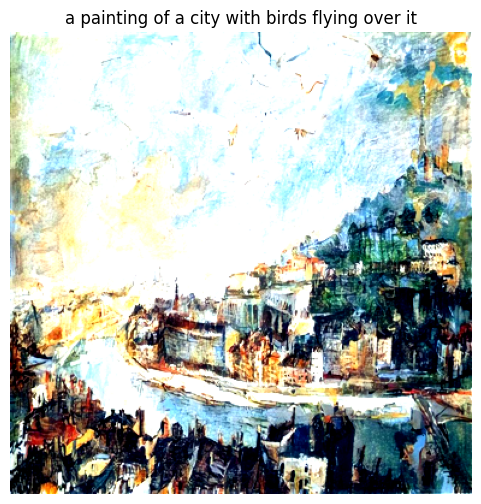

In [7]:
show_one_blip_example(test_loader)


In [8]:
import torch.nn as nn
from transformers import BlipForConditionalGeneration

model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Freeze vision encoder
for param in model.vision_model.parameters():
    param.requires_grad = False

# Wrap in DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"🔀 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model = model.to(device)

# Optimizer only for trainable parameters
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

🔀 Using 2 GPUs with DataParallel


In [9]:
import gc
gc.collect()
torch.cuda.empty_cache()


🟢 Epoch 1/3


Epoch 1 [Train]:   0%|                                                      | 0/157 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Epoch 1 [Train]: 100%|████████████████████████████████| 157/157 [08:39<00:00,  3.31s/it, loss=0.055]


Avg Train Loss: 2.2799


Epoch 1 [Val]:   0%|                                            | 0/157 [00:02<?, ?it/s, loss=0.065]

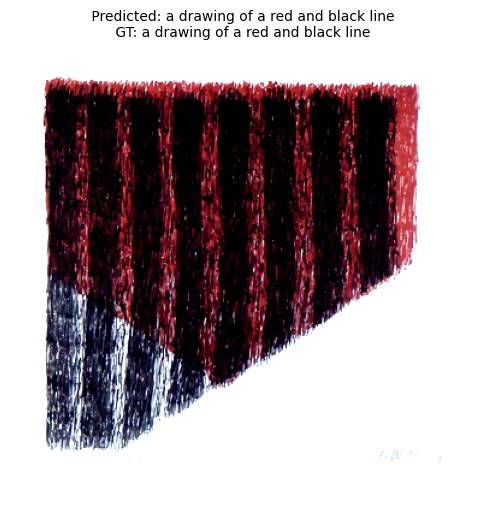

Epoch 1 [Val]: 100%|██████████████████████████████████| 157/157 [07:35<00:00,  2.90s/it, loss=0.071]


Avg Val Loss: 0.0659
Epoch 1: Avg Val Loss: 0.0659 ,Avg Train Loss: 2.2799 

🟢 Epoch 2/3


Epoch 2 [Train]: 100%|████████████████████████████████| 157/157 [06:58<00:00,  2.66s/it, loss=0.019]


Avg Train Loss: 0.0412


Epoch 2 [Val]:   1%|▏                                   | 1/157 [00:04<06:34,  2.53s/it, loss=0.046]

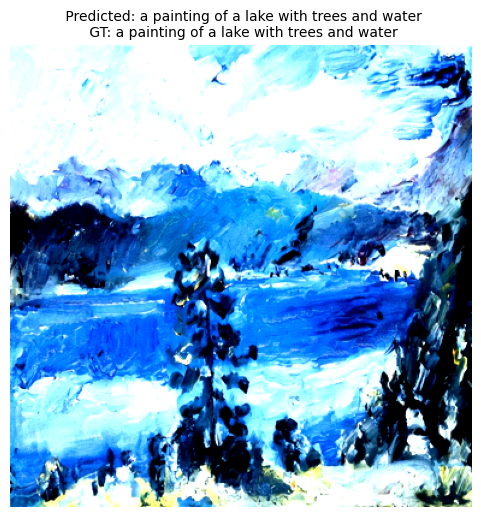

Epoch 2 [Val]: 100%|██████████████████████████████████| 157/157 [06:01<00:00,  2.31s/it, loss=0.043]


Avg Val Loss: 0.0374
Epoch 2: Avg Val Loss: 0.0374 ,Avg Train Loss: 0.0412 

🟢 Epoch 3/3


Epoch 3 [Train]: 100%|████████████████████████████████| 157/157 [07:00<00:00,  2.68s/it, loss=0.016]


Avg Train Loss: 0.0224


Epoch 3 [Val]:   1%|▍                                   | 2/157 [00:06<06:06,  2.36s/it, loss=0.037]

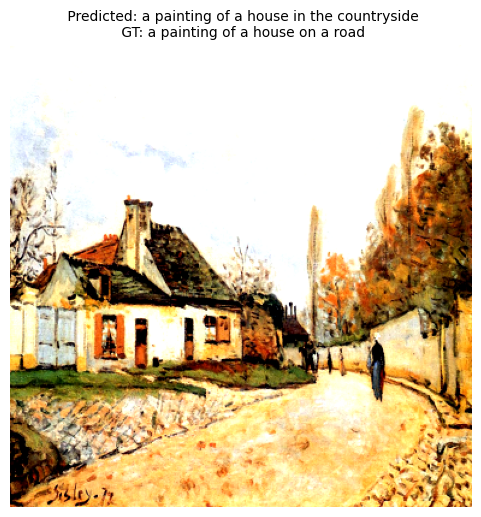

Epoch 3 [Val]: 100%|██████████████████████████████████| 157/157 [06:08<00:00,  2.34s/it, loss=0.043]


Avg Val Loss: 0.0307
Epoch 3: Avg Val Loss: 0.0307 ,Avg Train Loss: 0.0224 
✅ Model saved to blip_model.pth


In [10]:
from tqdm import tqdm
from torch.amp import GradScaler, autocast  # Correct import for autocast and GradScaler
import matplotlib.pyplot as plt

# Initialize GradScaler
scaler = GradScaler()
num_epochs = 3

for epoch in range(num_epochs):
    print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=True, ncols=100)

    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        # Specify the device type in autocast (e.g., 'cuda')
        with autocast(device_type='cuda'):  # Ensure correct device specification
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss.mean()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.3f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Avg Train Loss: {avg_loss:.4f}")

    # 🔍 Validation
    model.eval()
    val_loss = 0.0
    val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Val]", leave=True, ncols=100)

    with torch.no_grad():
        for i, batch in enumerate(val_pbar):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Specify the device type in autocast (e.g., 'cuda')
            with autocast(device_type='cuda'):  # Ensure correct device specification
                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                batch_loss = outputs.loss.mean().item()
                val_loss += batch_loss

            val_pbar.set_postfix(loss=f"{batch_loss:.3f}")

            if i == epoch:
                generated_ids = model.module.generate(pixel_values=pixel_values[:1])
                generated_caption = processor.tokenizer.decode(
                    generated_ids[0], skip_special_tokens=True
                )
                reference_caption = processor.tokenizer.decode(
                    labels[0], skip_special_tokens=True
                )
                img = pixel_values[0] * 0.5 + 0.5
                img = img.permute(1, 2, 0).cpu().numpy()

                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f" Predicted: {generated_caption}\n GT: {reference_caption}", fontsize=10)
                plt.show()

    avg_val_loss = val_loss / len(valid_loader)
    print(f"Avg Val Loss: {avg_val_loss:.4f}")
    print(f"Epoch {epoch+1}: Avg Val Loss: {avg_val_loss:.4f} ,Avg Train Loss: {avg_loss:.4f} ")

# At the end of training
torch.save(model.module.state_dict(), "blip_model.pth")
print("✅ Model saved to blip_model.pth")

In [11]:
torch.save(model, "blip_model_full.pth")

In [12]:
model = torch.load("blip_model_full.pth")
model.to(device)

/tmp/ipykernel_31/3175857558.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("blip_model_full.pth")


DataParallel(
  (module): BlipForConditionalGeneration(
    (vision_model): BlipVisionModel(
      (embeddings): BlipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (encoder): BlipEncoder(
        (layers): ModuleList(
          (0-11): 12 x BlipEncoderLayer(
            (self_attn): BlipAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): BlipMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        

In [13]:
model.eval()

DataParallel(
  (module): BlipForConditionalGeneration(
    (vision_model): BlipVisionModel(
      (embeddings): BlipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (encoder): BlipEncoder(
        (layers): ModuleList(
          (0-11): 12 x BlipEncoderLayer(
            (self_attn): BlipAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): BlipMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        

In [21]:
!pip install git+https://github.com/salaniz/pycocoevalcap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-zj5xm1m8
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-zj5xm1m8
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=bd7968f19ebc84796fad07b9cf3fa01baeb59db87a0d144819a9ce9e762168c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-zslks4rz/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [19]:
!pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=826c320fd3b356e71912d94705ad318ae7701fe14aa698c75286f224e6511cb3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [14]:
from transformers import BlipProcessor
from PIL import Image

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_caption(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.module.generate(**inputs)  # use model.module because of DataParallel
    return processor.decode(output[0], skip_special_tokens=True)


In [24]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tqdm import tqdm
from transformers import BlipProcessor

from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# Initialize
smoothie = SmoothingFunction().method4
rouge_scorer_ = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

all_bleu1, all_bleu2, all_bleu3, all_bleu4 = [], [], [], []
exact_matches, all_rougeL = [], []
cider_refs, cider_hyps = {}, {}
spice_refs, spice_hyps = {}, {}

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model.eval()

img_id = 0  # for COCO-style reference dicts

for batch in tqdm(test_loader):
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"]

    references = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    with torch.no_grad():
        generated_ids = model.module.generate(pixel_values=pixel_values, max_length=30)
        predictions = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = ref.split()

        all_bleu1.append(sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie))
        all_bleu2.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
        all_bleu3.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
        all_bleu4.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

        exact_matches.append(int(pred.strip().lower() == ref.strip().lower()))
        all_rougeL.append(rouge_scorer_.score(ref, pred)["rougeL"].fmeasure)

        # COCO-style dicts for CIDEr / SPICE
        cider_refs[img_id] = [ref]
        cider_hyps[img_id] = [pred]
        spice_refs[img_id] = [ref]
        spice_hyps[img_id] = [pred]
        img_id += 1

# Scoring CIDEr & SPICE
cider_score, _ = Cider().compute_score(cider_refs, cider_hyps)
spice_score, _ = Spice().compute_score(spice_refs, spice_hyps)

# Final results
print(f"BLEU-1: {sum(all_bleu1)/len(all_bleu1):.4f}")
print(f"BLEU-2: {sum(all_bleu2)/len(all_bleu2):.4f}")
print(f"BLEU-3: {sum(all_bleu3)/len(all_bleu3):.4f}")
print(f"BLEU-4: {sum(all_bleu4)/len(all_bleu4):.4f}")
print(f"ROUGE-L: {sum(all_rougeL)/len(all_rougeL):.4f}")
print(f"Exact Match: {sum(exact_matches)/len(exact_matches):.4f}")
print(f"CIDEr: {cider_score:.4f}")
print(f"SPICE: {spice_score:.4f}")


100%|██████████| 313/313 [35:14<00:00,  6.76s/it]
Parsing reference captions
Parsing test captions


SPICE evaluation took: 6.406 s
BLEU-1: 0.7744
BLEU-2: 0.7336
BLEU-3: 0.6991
BLEU-4: 0.6617
ROUGE-L: 0.8030
Exact Match: 0.3823
CIDEr: 5.7693
SPICE: 0.6858


In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

def generate_caption_and_show(image_path, model, processor, device):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Generate caption
    model.eval()
    with torch.no_grad():
        generated_ids = model.module.generate(pixel_values=inputs["pixel_values"], max_length=30)
        caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Show image with caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=14)
    plt.show()

    return caption


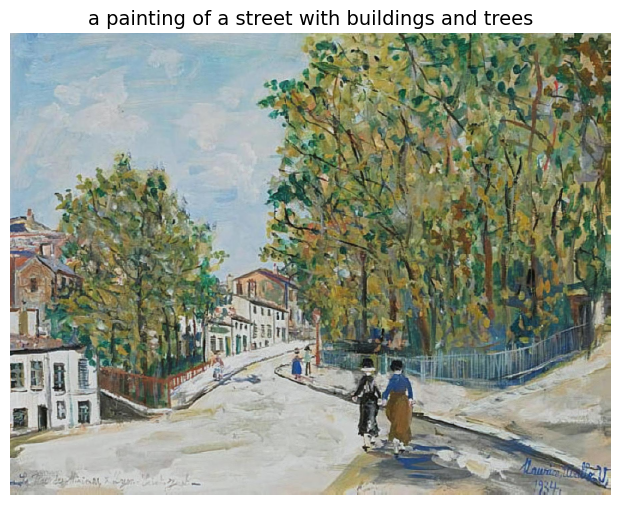

In [26]:
image_path = "/kaggle/input/wikiart/Post_Impressionism/maurice-utrillo_square-minimes.jpg"
caption = generate_caption_and_show(image_path, model, processor, device)

In [27]:
print(True)

True
